<a href="https://colab.research.google.com/github/xcomponent/chatbot-nlp/blob/main/compare_tfidf_vs_bert_features_in_intent_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

This notebook studies the use of different feature embeddings in intent prediction.

In the following, we compare two features which are usually used in NLP tasks: 
- TF-IDF 
- BERT-based semantic features

These features will by passed to different classification algorithms(SVM, logistic regression) to evaluate their performance. 

# Install / initialize

In [1]:
from google.colab import drive
drive.mount('/colab-data-drive')

Mounted at /colab-data-drive


In [ ]:
!pip install transformers
!pip install sentencepiece
!pip install sentence_transformers

In [3]:
import pandas
import numpy as np
from sklearn.cluster import KMeans

import matplotlib.pyplot as plt
import seaborn as sns

import sentence_transformers
from sentence_transformers import SentenceTransformer, util
from transformers import AutoConfig, AutoModel, AutoTokenizer

import torch

from collections import Counter

from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

from sklearn.model_selection import GridSearchCV

from pprint import pprint

import time

from sklearn.preprocessing import Normalizer


# Reference data
https://nlpforfrench.fr/transformers/02_firstBert_fr.html

In [4]:
# url="https://raw.githubusercontent.com/nlpinfrench/nlpinfrench.github.io/master/source/labeled_data.csv"

# ref_df = pandas.read_csv(url,header=1,names = ['a','review','b','c','temps','e'])

# ref_df = ref_df[["review","temps"]]
# ref_df.sample(5)

# print('Number of sentences: {:,}\n'.format(ref_df.shape[0]))
# print('Number of sentences per class :')
# print(ref_df['temps'].value_counts())

# Configs

In [5]:
pre_trained_model = "camembert-base" #@param ["camembert-base","camembert/camembert-base-wikipedia-4gb",'bert-base-multilingual-cased','bert-base-multilingual-uncased']

In [6]:
features_name = "tfidf" #@param ["tfidf", "bert_1_layer", "bert_4_layers_concatenated", "bert_4_layers_avg", "bert_4_layers_max"]

In [7]:
classifier = None
classifier_name = "SVM" #@param ["LogisticRegression", "SVM"]

# Load and prepare data

### Training data

In [8]:
def load_data(training_data_fn):

    messages = []

    df = pandas.read_excel(training_data_fn, header = None)

    return df

In [9]:
training_data_fn=r"/colab-data-drive/MyDrive/Colab Notebooks/data/training_data/6377b04fa1ef9405a2a0575b_training_data_FR.xlsx" # 39 intents smalltalks
# training_data_fn=r"/colab-data-drive/MyDrive/Colab Notebooks/data/training_data/pfs_SAV_training_data_FR.xlsx" # pfs SAV

df = load_data(training_data_fn)

all_messages = []
all_intents = []

intents_id_name = {}

for i, row in df.iterrows():
  message, intent, intent_name, language = row
  all_messages.append(message)
  all_intents.append(intent_name)

  if intent not in intents_id_name:
      intents_id_name[intent] = intent_name

print(f"Training data has {len(all_messages)} messages")
print(f"Training data contains {len(set(all_intents))} intents")

Training data has 687 messages
Training data contains 39 intents


## Testing data

In [10]:
testing_data_fn = None

In [11]:
# uncomment this cell for "pfs SAV - testing NT"
# testing_data_fn = r"/colab-data-drive/MyDrive/Colab Notebooks/data/testing_data/pfs_SAV_testing_data_FR.xlsx" # pfs SAV

# df = load_data(testing_data_fn)

# test_messages = []
# test_labels = []


# for i, row in df.iterrows():
#   message, intent, intent_name, language = row
#   test_messages.append(message)
#   test_labels.append(intent_name)

# print(f"Testing data has {len(test_messages)} messages")
# print(f"Testing data contains {len(set(test_labels))} intents")


## Select subset of data to study

In [12]:
nb_samples = len(all_messages) 

messages = all_messages[:nb_samples]
intents = all_intents[:nb_samples]

all_intents_name = list(set(intents))

nb_phrases_in_intents = Counter(intents)

print(f'Data to study has : {len(all_intents_name)} intents')
for name, count in nb_phrases_in_intents.items():
    print(f"\t{name} : {count}")

Data to study has : 39 intents
	Demander une réponse au chatbot : 12
	Dire au Chatbot que je veux le tester : 9
	Être content de reparler au Chatbot : 39
	Saluer le chatbot : 13
	Souhaiter une bonne nuit : 11
	Souhaiter une bonne matinée : 6
	Dire bonsoir : 10
	Dire au revoir : 10
	Remercier le chatbot : 26
	Demander les origines du chatbot : 10
	Demander des informations sur le Chatbot : 16
	Demander au chatbot s'il est réel : 21
	Demander le nom du Chatbot : 5
	Prendre des nouvelles du chatbot : 7
	Être fatigué : 14
	Vouloir bavarder : 19
	Être triste : 11
	Apprécier le chatbot : 12
	Plaisanter : 14
	Être heureux : 12
	Être enthousiaste : 5
	S'ennuyer : 11
	Être énervé : 20
	Être content de revoir le Chatbot : 38
	Être enchanté de faire la rencontre : 23
	Être surpris : 11
	Rigoler : 8
	Être désolé : 27
	Demander au Chatbot s'il est encore là : 15
	Demander au Chatbot de parler : 10
	Demander où se trouve le chatbot : 20
	Dire au Chatbot qu'il est mon ami : 30
	Demander au Chatbot s'

## Number training per class

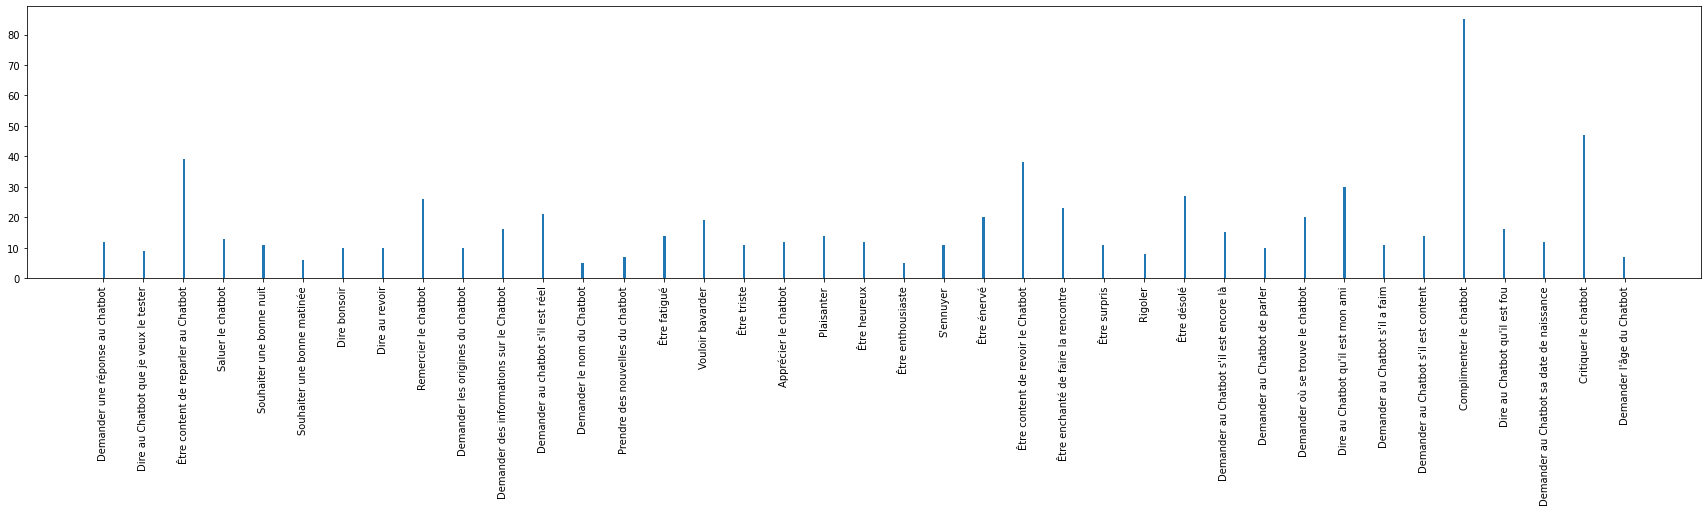

In [13]:
plt.figure(figsize=(30,5))
plt.hist(intents, bins=len(intents))
plt.xticks(rotation='vertical')
plt.show()

# Extract TFIDF

In [14]:
import nltk
nltk.download('stopwords')

from nltk.corpus import stopwords
import re

import pandas 

from sklearn.feature_extraction.text import TfidfVectorizer

from nltk.stem.snowball import FrenchStemmer
from nltk.stem import *


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [15]:
alphanumeric_characters = {
    "fr": "a-zA-ZàâäôéèëêïîçùûüÿæœÀÂÄÔÉÈËÊÏÎŸÇÙÛÜÆŒ0-9",
    "en": "a-zA-Z0-9"
}

words_unsplitted = ["don't", "you're", "i'm",
                    "aujourd'hui", "n'es", "n'est", "n'êtes", "d'accord"]

def tokenize_text(text, language):
    delimiter_pattern = '[^' + alphanumeric_characters[language] + ']'

    words = text.split()

    tokens = []
    for word in words:
        if word not in words_unsplitted:
            tokens = tokens + re.split(delimiter_pattern, word)
        else:
            tokens.append(word)

    tokens = filter(lambda x: len(x) > 1, tokens)
    tokens = [w.lower() for w in tokens]

    return tokens

In [16]:
tokenize_text("peux tu m'aider espresso-pan-conna", 'fr')

['peux', 'tu', 'aider', 'espresso', 'pan', 'conna']

In [17]:
def _customize_stopwords(text_list):
    """
    If stopword is present in a short training phrase (e.g. < 5 words), do not consider it as stopword.
    :param text_list:
    :return:
    """

    # custom stopwords
    raw_stopwords = list(set(stopwords.words('french')))

    words_of_short_texts = []
    for text in text_list:
        text_words = tokenize_text(text=text, language='fr')
        if len(text_words) <= 5:
            words_of_short_texts.extend(tokenize_text(text=text, language='fr'))

    selected_stopwords = [stw for stw in raw_stopwords if stw not in words_of_short_texts]

    included_stw = ['in', 'on', 'of', 'and']  # add english stw
    selected_stopwords = selected_stopwords + included_stw

    print(f'{len(selected_stopwords)} selected stopwords')
    print(f'{(selected_stopwords)}')

    return selected_stopwords

In [18]:
class Stemming(object):
    def __init__(self):
        self.fr_stm = FrenchStemmer(ignore_stopwords=True)
        self.en_stm = SnowballStemmer("english", ignore_stopwords=True)

    def __call__(self, text, language='fr'):

        # TODO: different tfidf vectorizers, stemmers for en and fr
        language = 'fr'
        if language == 'en':
            return [self.en_stm.stem(t) for t in tokenize_text(text, language)]
        elif language == 'fr':
            return [self.fr_stm.stem(t) for t in tokenize_text(text, language)]

In [19]:
def train_tfidf(messages):
        # custom stopwords
        stw = _customize_stopwords(text_list=messages)

        vectorizer = TfidfVectorizer(lowercase=True, stop_words=stw, use_idf=True,
                                     tokenizer=Stemming(), ngram_range=(1, 1))
        vectorizer.fit(messages)

        print(f"{len(vectorizer.get_feature_names_out())} words in vocabulary")
        print(vectorizer.get_feature_names_out())

        return vectorizer

def transform_tfidf(vectorizer, messages):

        return vectorizer.transform(messages)

In [20]:
def preprocess_messages(messages):
  
  cleaned_messages = []

  stw = _customize_stopwords(messages)

  for m in messages: 
    cleaned_m = " ".join([w for w in m.split() if w not in stw])
    cleaned_messages.append(cleaned_m)
    if m != cleaned_m:
      print(f"{m} : {cleaned_m}")

  return cleaned_messages

In [21]:
# messages = preprocess_messages(messages)

In [22]:
vectorizer = train_tfidf(messages)
tfidf = transform_tfidf(vectorizer, messages)

115 selected stopwords
['étaient', 'à', 'étées', 'eusse', 'fus', 'êtes', 'eûtes', 'l', 'étais', 'aurait', 'les', 'vos', 't', 'du', 'ses', 'avions', 'aurions', 'eu', 'nos', 'mais', 'son', 'soient', 'y', 'serions', 'seriez', 'avais', 'votre', 'eût', 'sa', 'soit', 'eusses', 'lui', 'ayant', 'aurai', 'serons', 'aient', 'étants', 'aviez', 'avez', 'étés', 'auront', 'eurent', 'fussiez', 'eussiez', 'aux', 'avait', 'ayantes', 'avaient', 'étiez', 'sois', 'furent', 'fut', 'serai', 'ayants', 'eue', 'auras', 'fût', 'aura', 'fûtes', 'notre', 'seraient', 'eus', 'd', 'fûmes', 'eues', 'par', 'sur', 'j', 'serait', 'ont', 'eûmes', 'elle', 'aie', 'm', 'fussions', 'eux', 'avons', 'ils', 'sommes', 'c', 'auriez', 'leur', 'ait', 'seront', 'n', 'ayez', 'ces', 'aies', 'fusse', 'étante', 'serez', 'eussent', 'étions', 'auraient', 'aurez', 'soyez', 'étée', 'seras', 'ayons', 'fusses', 'soyons', 'étantes', 'étant', 'sera', 'aurons', 'aurais', 'eut', 'eussions', 'ayante', 'fussent', 's', 'in', 'on', 'of', 'and']
295 w

/usr/local/lib/python3.8/dist-packages/sklearn/feature_extraction/text.py:516: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [23]:
print(messages[0])

j'ai une question


In [24]:
print(f"Shape of tfidf of training data :  {tfidf.shape}")
print(f"\t{tfidf.shape[0]} vectors tfidf")
print(f"\t{tfidf.shape[1]} dimensions in each vector")

Shape of tfidf of training data :  (687, 295)
	687 vectors tfidf
	295 dimensions in each vector


In [25]:
if testing_data_fn:
  testing_tfidf = transform_tfidf(vectorizer, test_messages)
  print(f"Shape of tfidf of testing data :  {testing_tfidf.shape}")
  print(f"\t{testing_tfidf.shape[0]} vectors tfidf")
  print(f"\t{testing_tfidf.shape[1]} dimensions in each vector")

# Extract BERT features

### Initialize model

In [26]:
config = AutoConfig.from_pretrained(pre_trained_model, output_hidden_states=True)
model = AutoModel.from_pretrained(pre_trained_model, config=config)
tokenizer = AutoTokenizer.from_pretrained(pre_trained_model, do_lower_case=True)


Some weights of the model checkpoint at camembert-base were not used when initializing CamembertModel: ['lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.bias']
- This IS expected if you are initializing CamembertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing CamembertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


### Tokenize 

In [27]:
def extract_bert_output(messages):

  tokenized_messages = tokenizer(
      messages,
      add_special_tokens=True,
      # padding="longest",
      max_length=100,
      padding="max_length",
      truncation=True,
      return_tensors="pt"
  )

  print(f"Nb of tokenized messages : {len(tokenized_messages.input_ids)}")
  print(f"Size of tokenized message (with padding) : {len(tokenized_messages.input_ids[0])}")

  sentences_tokens = [tokenizer.convert_ids_to_tokens(sentence_input_ids) for sentence_input_ids in tokenized_messages['input_ids']]
  for st in sentences_tokens[0]: 
      pprint([t for t in st][:30], width=150)

  print('\nLongest sentences :')
  for st in sentences_tokens: 
      if len(st) == len(tokenized_messages.input_ids[0]) and '<pad>' not in st:
        pprint([t for t in st][:30], width=150)

  with torch.no_grad():
      model_output = model(**tokenized_messages, output_hidden_states=True)

  return model_output

In [ ]:
model_output = extract_bert_output(messages)

In [29]:
testing_model_output = None

if testing_data_fn:
  testing_model_output = extract_bert_output(test_messages)

## Extract last hidden layer
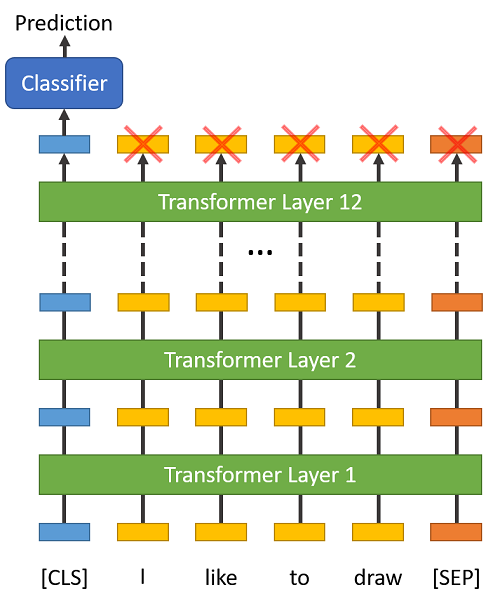

In [30]:
# hidden representations for each token in each sequence of the batch
print(f'Training data :')
print(f"\tShape of last hidden state in output : {model_output.last_hidden_state.shape}")
print(f"\tNumber of hidden states : {len(model_output.hidden_states)}")

if testing_data_fn:
  print(f'Testing data :')
  print(f"\tShape of last hidden state in output : {testing_model_output.last_hidden_state.shape}")
  print(f"\tNumber of hidden states : {len(testing_model_output.hidden_states)}")


Training data :
	Shape of last hidden state in output : torch.Size([687, 100, 768])
	Number of hidden states : 13


In [31]:
bert_features = model_output.last_hidden_state[:,0,:]

if testing_data_fn:
  testing_bert_features = testing_model_output.last_hidden_state[:,0,:]


In [32]:
print(bert_features.shape)

if testing_data_fn:
  print(testing_bert_features.shape)

torch.Size([687, 768])


In [33]:
bert_features[0]

tensor([-7.3174e-02,  1.2458e-01,  1.0263e-01, -1.7118e-01, -1.2582e-03,
         5.6968e-02,  2.1315e-02,  2.4261e-01,  2.3553e-03,  1.9085e-01,
        -2.1273e-02,  1.3765e-01, -3.4789e-02,  8.5201e-02,  2.9978e-01,
        -3.4640e-02, -8.7928e-03, -5.4016e-02,  6.3165e-02, -1.8941e-01,
         1.8459e-02, -1.1943e-01,  1.7526e-02, -2.7623e-01,  1.7014e-01,
        -1.7124e-01, -1.4844e-02, -7.5239e-02, -7.4894e-02,  2.7045e-02,
         3.6821e-02, -2.5106e-01,  1.7001e-01,  9.6920e-02,  1.0878e-01,
        -9.3555e-02, -9.9277e-02,  1.9683e-01, -1.2687e-01, -1.4408e-02,
        -2.0225e-01,  1.4373e-01,  1.4816e-01, -2.7760e-02,  2.0939e-02,
         1.8482e-01, -2.5626e-01,  6.7797e-02, -4.5383e-02,  7.1551e-02,
         2.1650e-02, -2.6728e-02, -4.9787e-01,  1.7052e-01, -1.4214e-02,
         7.4180e-02, -4.6517e-03, -1.0053e-01,  1.4897e-01,  1.0752e-02,
         4.7160e-02,  4.6161e-02,  9.6796e-02,  5.0617e-03, -1.9393e-02,
         8.0799e-02, -9.5398e-02,  1.2692e-01,  5.9

## Combining last hidden states 

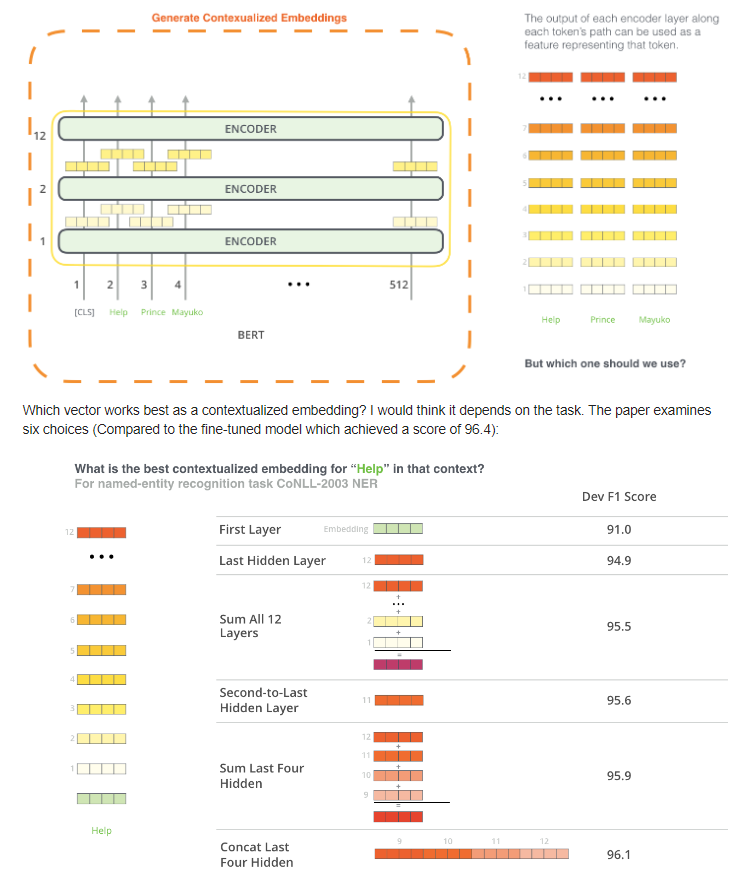

Source : http://jalammar.github.io/illustrated-bert/

### Concatenation

In [34]:
bert_4_layers_concatenated = torch.cat(tuple([model_output.hidden_states[i] for i in [-4, -3, -2, -1]]), dim=-1)
bert_4_layers_concatenated = bert_4_layers_concatenated[:, 0, :]
print(bert_4_layers_concatenated.shape)

if testing_data_fn:
  testing_bert_4_layers_concatenated = torch.cat(tuple([testing_model_output.hidden_states[i] for i in [-4, -3, -2, -1]]), dim=-1)
  testing_bert_4_layers_concatenated = testing_bert_4_layers_concatenated[:, 0, :]
  print(testing_bert_4_layers_concatenated.shape)

torch.Size([687, 3072])


In [ ]:
# test
bert_4_layers_concatenated[10, -768:] == bert_features[10]

### Mean pooling

In [36]:
bert_4_layers_avg = [model_output.hidden_states[i][:, 0, :] for i in [-4, -3, -2, -1]]
bert_4_layers_avg = torch.stack(bert_4_layers_avg, dim=1)
bert_4_layers_avg = torch.mean(bert_4_layers_avg, dim=1)
print(bert_4_layers_avg.shape)

if testing_data_fn:
  testing_bert_4_layers_avg = [testing_model_output.hidden_states[i][:, 0, :] for i in [-4, -3, -2, -1]]
  testing_bert_4_layers_avg = torch.stack(testing_bert_4_layers_avg, dim=1)
  testing_bert_4_layers_avg = torch.mean(testing_bert_4_layers_avg, dim=1)
  print(testing_bert_4_layers_avg.shape)

torch.Size([687, 768])


In [37]:
bert_4_layers_avg[0]

tensor([-1.7565e-02,  3.3650e-02,  1.2822e-02, -6.7238e-02,  4.6930e-03,
         1.8761e-02,  3.3632e-03,  6.3148e-02, -1.0030e-02,  3.6905e-02,
        -3.5349e-03,  1.7032e-02,  1.9071e-03,  1.1593e-02,  7.3893e-02,
        -1.0289e-03, -5.7755e-03,  1.5230e-03,  1.4516e-02, -4.1334e-02,
        -6.1392e-03, -3.4776e-02, -1.7669e-02, -6.1088e-02,  8.4762e-02,
        -2.2312e-02, -1.3737e-02, -2.9700e-02, -1.6064e-02,  1.1848e-02,
         4.0456e-03, -6.8519e-02,  4.6865e-02,  2.9188e-02,  3.8047e-02,
        -2.8625e-02, -2.4122e-02,  5.7673e-02, -4.4534e-02,  1.2329e-02,
        -5.1142e-02,  3.5486e-02,  3.9577e-02, -8.7407e-03,  5.1353e-03,
         4.6583e-02, -5.3286e-02,  9.4732e-02, -1.3186e-02,  1.1470e-02,
        -2.8764e-03,  3.1069e-03, -1.8958e-01,  4.9125e-02, -1.1603e-02,
         6.9674e-03,  1.6622e-04, -7.0327e-02,  3.8642e-02,  1.9445e-02,
         7.5539e-03,  1.6627e-03,  2.4063e-02, -2.1995e-03,  7.0724e-03,
         4.4370e-02, -1.0208e-02,  2.9639e-02,  2.0

In [38]:
# test to validate
s = 0
for i in [-4, -3, -2, -1]:
    embedding_i = model_output.hidden_states[i][0, 0, :]
    print(embedding_i.shape)
    print(embedding_i[5])
    s += embedding_i[5]

print(f'mean : {s/4.0}')

torch.Size([768])
tensor(0.0014)
torch.Size([768])
tensor(0.0010)
torch.Size([768])
tensor(0.0156)
torch.Size([768])
tensor(0.0570)
mean : 0.018760617822408676


### Max pooling


In [39]:
bert_4_layers_max = [model_output.hidden_states[i][:, 0, :] for i in [-4, -3, -2, -1]]
bert_4_layers_max = torch.stack(bert_4_layers_max, dim=1)
bert_4_layers_max = torch.max(bert_4_layers_max, dim=1)
bert_4_layers_max = bert_4_layers_max.values
print(bert_4_layers_max.shape)

if testing_data_fn:
  testing_bert_4_layers_max = [testing_model_output.hidden_states[i][:, 0, :] for i in [-4, -3, -2, -1]]
  testing_bert_4_layers_max = torch.stack(testing_bert_4_layers_max, dim=1)
  testing_bert_4_layers_max = torch.max(testing_bert_4_layers_max, dim=1)
  testing_bert_4_layers_max = testing_bert_4_layers_max.values
  print(testing_bert_4_layers_max.shape)

torch.Size([687, 768])


In [40]:
# test to validate
# each element in hidden_states : [# layers, # batches, # tokens, # features]
max_values = []
look_at_position = -2

for i in [-4, -3, -2, -1]:
    embedding_1st_token_1st_message_at_layer_i = model_output.hidden_states[i][0, 0, :]
    # print(embedding_1st_token_1st_message_at_layer_i.shape)
    print(embedding_1st_token_1st_message_at_layer_i[look_at_position])
    max_values.append(embedding_1st_token_1st_message_at_layer_i[look_at_position])

print(f'max : {max(max_values)}')

tensor(-0.0015)
tensor(0.0246)
tensor(0.0048)
tensor(-0.0931)
max : 0.02455226331949234


In [41]:
bert_4_layers_max[0][look_at_position]

tensor(0.0246)

# Classify intents

In [42]:
configs_name = f"{len(all_intents_name)}intents=={pre_trained_model}=={features_name}=={classifier_name}"
print(configs_name)

39intents==camembert-base==tfidf==SVM


## Select features & model name

In [43]:
features = None

if features_name == "bert_1_layer":
  features = bert_features
if features_name == "bert_4_layers_concatenated":
  features = bert_4_layers_concatenated
if features_name == "bert_4_layers_avg":
  features = bert_4_layers_avg
if features_name == "bert_4_layers_max":
  features = bert_4_layers_max
if features_name == "tfidf":
  features = tfidf

In [44]:
print(f"Features name : {features_name}")
print(f"Features shape : {features.shape}")
print(features[0])

Features name : tfidf
Features shape : (687, 295)
  (0, 269)	0.45762025500619585
  (0, 208)	0.6579561373456513
  (0, 6)	0.5980613877665526


In [45]:
test_features = None

if testing_data_fn:

  if features_name == "bert_1_layer":
    test_features = testing_bert_features
  if features_name == "bert_4_layers_concatenated":
    test_features = testing_bert_4_layers_concatenated
  if features_name == "bert_4_layers_avg":
    test_features = testing_bert_4_layers_avg
  if features_name == "bert_4_layers_max":
    test_features = testing_bert_4_layers_max
  if features_name == "tfidf":
    test_features = testing_tfidf

  print(f"Testing features name : {features_name}")
  print(f"Testing features shape : {test_features.shape}")
  print(test_features[0])

## Normalize

In [46]:
def normalize_bert_features(features):

  if features_name == "tfidf":
    return features

  transformer = Normalizer().fit(features)
  features = transformer.transform(features)

  print(f"Features name : {features_name}")
  print(f"Features shape : {features.shape}")

  return features

In [47]:
features = normalize_bert_features(features)

if testing_data_fn:
  test_features = normalize_bert_features(test_features)

## Split to train and test

In [48]:
if not testing_data_fn:
  train_messages, test_messages, train_features, test_features, train_labels, test_labels = train_test_split(messages, features, intents, test_size=0.2, stratify=intents, random_state=42)
else:
  train_messages = messages
  train_features = features
  train_labels = intents

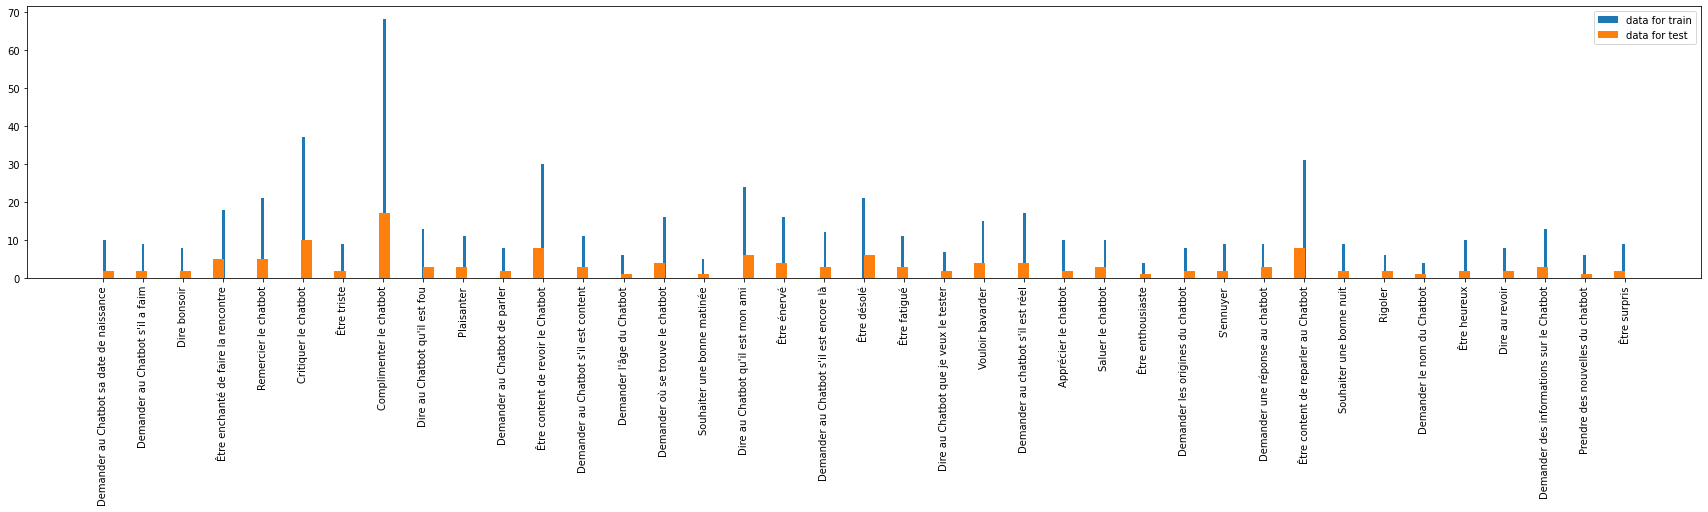

In [49]:
plt.figure(figsize=(30,5))
plt.hist(train_labels, bins=len(train_labels), label="data for train")
plt.hist(test_labels, bins=len(test_labels), label="data for test")
plt.legend(loc='upper right')

plt.xticks(rotation='vertical')
plt.show()

In [50]:
if features_name == "tfidf":
  train_features = train_features.toarray()
  test_features = test_features.toarray()

print(len(train_features))
print(len(test_features))

print(len(train_features) / (len(train_features) + len(test_features)))
print(len(test_features) / (len(train_features) + len(test_features)))


549
138
0.7991266375545851
0.20087336244541484


In [51]:
# display training and testing messages for each intent
for intent_ in list(set(all_intents)):
  print(f'{intent_}')
  print(f'\tTrainings:')
  for i in range(len(train_labels)):
    if train_labels[i] == intent_:
      print(f'\t\t{train_messages[i]}')
  print(f'\tTestings:')
  for i in range(len(test_labels)):
    if test_labels[i] == intent_:
      print(f'\t\t{test_messages[i]}')
  

Apprécier le chatbot
	Trainings:
		tu me plais aussi
		je t'aime bien aussi
		je t'aime bien
		je t'aime bien également
		je t'aime bien moi aussi
		tu me plais
		tu me plais bien
		tu me plais bien aussi toi
		toi aussi tu me plais
		tu me plais beaucoup
	Testings:
		moi aussi tu me plais
		toi aussi tu me plais
Dire au Chatbot que je veux le tester
	Trainings:
		pourrais-je te tester un peu
		je suis en train de te tester
		est-ce possible de te tester
		je veux te tester
		j'aimerais te tester
		puis-je te tester
		je te teste
	Testings:
		je te teste en fait
		est-ce que je peux te tester
Demander les origines du chatbot
	Trainings:
		dis-moi d'où tu viens
		d'où tu viens
		quel est ton pays d'origine
		d'où es-tu
		quelles origines as-tu
		quelles sont tes origines
		d'où viens-tu
		d'où est-ce que tu viens
	Testings:
		c'est quoi ton pays d'origine
		tu es d'où
Dire au revoir
	Trainings:
		à la prochaine
		au plaisir
		a plus dans le bus
		à la revoyure
		à plus tard
		à bientôt


## Oversample training data 

In [52]:
oversampled_train_labels = []
oversampled_train_features = []
oversampled_train_messages = []

training_counter = Counter(train_labels)

max_size_intent = max(training_counter.values())
print(f'Number of messages in the biggest intent : {max_size_intent}')

for intent_, count_ in training_counter.items():

  intent_phrases = []
  intent_features = []

  for i in range(len(train_labels)):
    if train_labels[i] == intent_:
      intent_phrases.append(train_messages[i])
      intent_features.append(train_features[i])

  print(f"\t{intent_} : {count_}")

  if count_ < max_size_intent:
    nb_dupplicate = max_size_intent // count_
    remainder = max_size_intent % count_
    
    print(f'\t\toversample : {nb_dupplicate} * {count_} + {remainder}')

    new_intent_phrases = intent_phrases * nb_dupplicate + intent_phrases[:remainder]
    new_intent_features = intent_features * nb_dupplicate + intent_features[:remainder]

    oversampled_train_labels = oversampled_train_labels + [intent_] * max_size_intent
    oversampled_train_features = oversampled_train_features + new_intent_features
    oversampled_train_messages = oversampled_train_messages + new_intent_phrases

    if not len(oversampled_train_labels) == len(oversampled_train_features) == len(oversampled_train_messages):
      print('NOT OK')

  else:
    oversampled_train_labels = oversampled_train_labels + [intent_] * max_size_intent
    oversampled_train_features = oversampled_train_features + intent_features
    oversampled_train_messages = oversampled_train_messages + intent_phrases

print(len(oversampled_train_labels))
print(len(oversampled_train_features))
print(len(oversampled_train_messages))

Number of messages in the biggest intent : 68
	Demander au Chatbot sa date de naissance : 10
		oversample : 6 * 10 + 8
	Demander au Chatbot s'il a faim : 9
		oversample : 7 * 9 + 5
	Dire bonsoir : 8
		oversample : 8 * 8 + 4
	Être enchanté de faire la rencontre : 18
		oversample : 3 * 18 + 14
	Remercier le chatbot : 21
		oversample : 3 * 21 + 5
	Critiquer le chatbot : 37
		oversample : 1 * 37 + 31
	Être triste : 9
		oversample : 7 * 9 + 5
	Complimenter le chatbot : 68
	Dire au Chatbot qu'il est fou : 13
		oversample : 5 * 13 + 3
	Plaisanter : 11
		oversample : 6 * 11 + 2
	Demander au Chatbot de parler : 8
		oversample : 8 * 8 + 4
	Être content de revoir le Chatbot : 30
		oversample : 2 * 30 + 8
	Demander au Chatbot s'il est content : 11
		oversample : 6 * 11 + 2
	Demander l'âge du Chatbot : 6
		oversample : 11 * 6 + 2
	Demander où se trouve le chatbot : 16
		oversample : 4 * 16 + 4
	Souhaiter une bonne matinée : 5
		oversample : 13 * 5 + 3
	Dire au Chatbot qu'il est mon ami : 24
		overs

In [53]:
train_labels = oversampled_train_labels
train_messages = oversampled_train_messages
train_features = oversampled_train_features

## Train model

In [54]:
if classifier_name == "LogisticRegression":
    classifier = LogisticRegression(random_state=42)

    parameters = {'C': np.linspace(0.0001, 100, 20)}

if classifier_name == "SVM":
    classifier = SVC(random_state=42, probability=True, class_weight='balanced')

    c_values = [1.0,10.0,100.0,500.0,1000.0]
    g_values = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
    d_values = [2,3,4]    
    parameters=[{'C': c_values,'kernel': ['linear']},
                {'C': c_values,'kernel': ['rbf'],'gamma': g_values} ,
                {'C': c_values,'kernel': ['poly'],'gamma': g_values,'degree': d_values}
               ]

In [55]:
start_time = time.time()

# Grid search
grid_search = GridSearchCV(classifier, parameters, cv=5)
grid_search.fit(train_features, train_labels)

print(f'Number of data for training : {len(train_features)}')
print(f'Number of intents : {len(set(train_labels))}')

print('Best parameters : ', grid_search.best_params_)
print('Best score : ', grid_search.best_score_)

print(f"Training time : {(time.time() - start_time)}")

Number of data for training : 2652
Number of intents : 39
Best parameters :  {'C': 1.0, 'degree': 4, 'gamma': 0.9, 'kernel': 'poly'}
Best score :  0.9996226415094339
Training time : 1931.0712537765503


In [56]:
print(f'Number of data for training : {len(train_features)}')
print(f'Number of intents : {len(set(train_labels))}')

Number of data for training : 2652
Number of intents : 39


In [57]:
if classifier_name == "LogisticRegression":
  classifier = LogisticRegression(**grid_search.best_params_)

if classifier_name == "SVM":
  classifier=SVC(**grid_search.best_params_, random_state=42, probability=True, class_weight='balanced')

print(classifier)

SVC(class_weight='balanced', degree=4, gamma=0.9, kernel='poly',
    probability=True, random_state=42)


In [58]:
classifier.fit(train_features, train_labels)

SVC(class_weight='balanced', degree=4, gamma=0.9, kernel='poly',
    probability=True, random_state=42)

## Confusion matrix

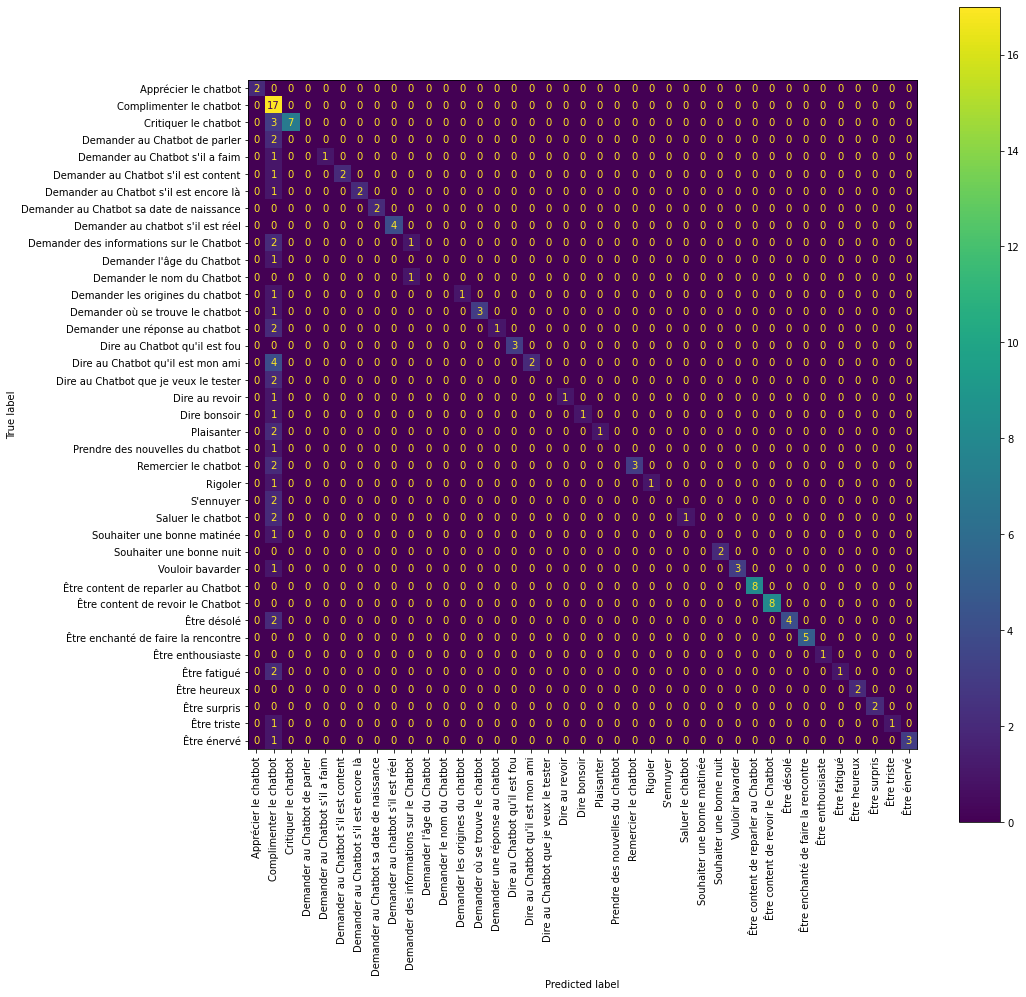

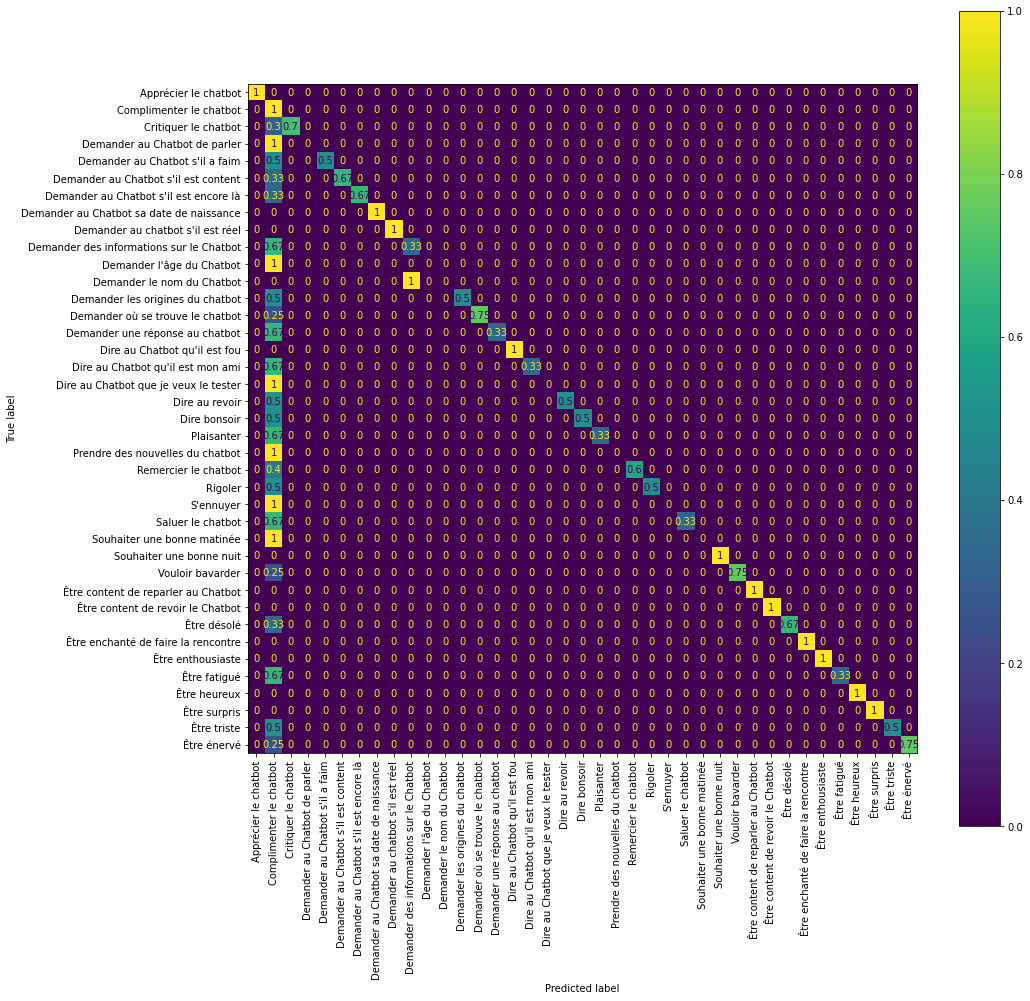

In [59]:
from sklearn.metrics import ConfusionMatrixDisplay

np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
titles_options = [
    ("Confusion matrix, without normalization", None),
    ("Normalized confusion matrix", "true"),
]
for title, normalize in titles_options:

    _, ax = plt.subplots(figsize=(15,15))

    disp = ConfusionMatrixDisplay.from_estimator(
        classifier,
        test_features,
        test_labels,
        # cmap=plt.cm.Blues,
        normalize=normalize,
        xticks_rotation='vertical',
        ax=ax
    )

    configs_name = configs_name.replace('/', '-')
    disp.figure_.savefig(f'{configs_name}==normalized{normalize}_CM.png')


In [60]:
from sklearn.metrics import confusion_matrix

predictions =classifier.predict(test_features)


nb_incorrect_detection = 0

for i in range(len(test_features)):
  if predictions[i] != test_labels[i]:
    nb_incorrect_detection += 1
    print(f"{test_messages[i]}")
    print(f"\tlabel {test_labels[i]} != predicted {predictions[i]}")

print(f'\nNumber of incorrect detection : {nb_incorrect_detection}')

super merci
	label Remercier le chatbot != predicted Complimenter le chatbot
je suis en colère
	label Être énervé != predicted Complimenter le chatbot
ok désolé
	label Être désolé != predicted Complimenter le chatbot
c'était une blague
	label Plaisanter != predicted Complimenter le chatbot
je te teste en fait
	label Dire au Chatbot que je veux le tester != predicted Complimenter le chatbot
je veux parler avec toi
	label Vouloir bavarder != predicted Complimenter le chatbot
T'es qui toi ?
	label Demander le nom du Chatbot != predicted Demander des informations sur le Chatbot
t'es ma meilleure copine
	label Dire au Chatbot qu'il est mon ami != predicted Complimenter le chatbot
je te souhaite une bonne matinée
	label Souhaiter une bonne matinée != predicted Complimenter le chatbot
je plaisante
	label Plaisanter != predicted Complimenter le chatbot
en quoi est-ce que ton travail consiste
	label Demander des informations sur le Chatbot != predicted Complimenter le chatbot
c'est trop triste


Observations on incorrect prediction :
1. Labeling not propre 

```
T'es qui toi ?
  label Demander le nom du Chatbot != predicted Demander des informations sur le Chatbot
```

2. Imbalanced classes 

```
c'est trop triste
  label Être triste (11 training) != predicted Complimenter le chatbot (>80 training)
```






In [61]:
from sklearn.metrics import classification_report

y_pred=classifier.predict(test_features)

print(classification_report(test_labels, y_pred, labels=list(set(test_labels))))

clsf_report = pandas.DataFrame(classification_report(y_true = test_labels, y_pred = y_pred, output_dict=True, labels=list(set(test_labels)))).transpose()
clsf_report.to_csv(f'{configs_name}_metrics.csv', index= True)


                                          precision    recall  f1-score   support

                    Apprécier le chatbot       1.00      1.00      1.00         2
   Dire au Chatbot que je veux le tester       0.00      0.00      0.00         2
        Demander les origines du chatbot       1.00      0.50      0.67         2
                             Être désolé       1.00      0.67      0.80         6
        Demander où se trouve le chatbot       1.00      0.75      0.86         4
                          Dire au revoir       1.00      0.50      0.67         2
               Demander l'âge du Chatbot       0.00      0.00      0.00         1
    Demander au Chatbot s'il est content       1.00      0.67      0.80         3
       Demander au chatbot s'il est réel       1.00      1.00      1.00         4
                            Être heureux       1.00      1.00      1.00         2
       Dire au Chatbot qu'il est mon ami       1.00      0.33      0.50         6
Demander des in

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classificat

## Evaluation metrics

In [62]:
from sklearn.metrics import accuracy_score, f1_score, precision_recall_curve

def evaluate(test_labels, y_pred):
    acc=accuracy_score(test_labels,y_pred)
    print('Accuracy : ', round(acc,2))

    f1_sc = f1_score(test_labels, y_pred, average='macro')
    print('F1 Score (macro) : ', round(f1_sc, 2))

    print(f'% incorrect detection : {round(nb_incorrect_detection / len(test_labels), 2)}')

In [63]:
evaluate(test_labels, y_pred)

Accuracy :  0.7
F1 Score (macro) :  0.64
% incorrect detection : 0.3


In [64]:
def intent_never_predicted(test_labels, test_pred):
  return set(test_labels) - set(test_pred)

print(f"These intents are never predicted for testing data :")
for i in intent_never_predicted(test_labels, y_pred):
  print(f"\t{i}")

These intents are never predicted for testing data :
	Demander le nom du Chatbot
	Dire au Chatbot que je veux le tester
	Prendre des nouvelles du chatbot
	Demander l'âge du Chatbot
	S'ennuyer
	Demander au Chatbot de parler
	Souhaiter une bonne matinée


## Examine acceptation threshold

In [65]:
# calculate score of the first intent
y_scores = classifier.predict_proba(test_features)

y_highest_scores = []

for y_score in y_scores:
  highest_score = max(zip(classifier.classes_, y_score), key=lambda x: x[1])
  y_highest_scores.append(highest_score)

min_score = min(y_highest_scores, key=lambda x: x[1])
max_score = max(y_highest_scores, key=lambda x: x[1])
print(f"Min score on test : {min_score[1]}")
print(f"Max score on test : {max_score[1]}")

# for i in range(len(test_messages)):
#   print(f"{test_messages[i]} : {y_highest_scores[i]}")

Min score on test : 0.1808075785474781
Max score on test : 0.9349425183381289


In [66]:
def decision(threshold, y_highest_scores, test_labels, test_messages):
  correct_pred = 0
  incorrect_pred = 0
  no_pred = 0

  for i in range(len(test_messages)):
    intent_, score_ = y_highest_scores[i]

    if score_ >= threshold:
      if intent_ == test_labels[i]:
        correct_pred += 1
      else:
        incorrect_pred += 1
    else:
      no_pred += 1

  return correct_pred, incorrect_pred, no_pred

In [67]:
thresholds = (0.05, 0.95, 0.05)

threshold_values = np.arange(thresholds[0], thresholds[1], thresholds[2])

threshold_values = [round(th, 2) for th in threshold_values]

correct_pred_values = []
incorrect_pred_values = []
no_pred_values = []

for th in threshold_values:
  cr, incr, npr = decision(th, y_highest_scores, test_labels, test_messages)

  print(f"Threshold = {th}")
  print(f"\t% correct pred : {cr}/{len(test_messages)} = {round(cr/len(test_messages), 2)}")
  print(f"\t% incorrect pred : {incr}/{len(test_messages)} = {round(incr/len(test_messages), 2)}")
  print(f"\t% no pred : {npr}/{len(test_messages)} = {round(npr/len(test_messages), 2)}")

  correct_pred_values.append(round(cr/len(test_messages), 2))
  incorrect_pred_values.append(round(incr/len(test_messages), 2))
  no_pred_values.append(round(npr/len(test_messages), 2))

Threshold = 0.05
	% correct pred : 88/138 = 0.64
	% incorrect pred : 50/138 = 0.36
	% no pred : 0/138 = 0.0
Threshold = 0.1
	% correct pred : 88/138 = 0.64
	% incorrect pred : 50/138 = 0.36
	% no pred : 0/138 = 0.0
Threshold = 0.15
	% correct pred : 88/138 = 0.64
	% incorrect pred : 50/138 = 0.36
	% no pred : 0/138 = 0.0
Threshold = 0.2
	% correct pred : 87/138 = 0.63
	% incorrect pred : 50/138 = 0.36
	% no pred : 1/138 = 0.01
Threshold = 0.25
	% correct pred : 82/138 = 0.59
	% incorrect pred : 45/138 = 0.33
	% no pred : 11/138 = 0.08
Threshold = 0.3
	% correct pred : 82/138 = 0.59
	% incorrect pred : 44/138 = 0.32
	% no pred : 12/138 = 0.09
Threshold = 0.35
	% correct pred : 82/138 = 0.59
	% incorrect pred : 41/138 = 0.3
	% no pred : 15/138 = 0.11
Threshold = 0.4
	% correct pred : 82/138 = 0.59
	% incorrect pred : 32/138 = 0.23
	% no pred : 24/138 = 0.17
Threshold = 0.45
	% correct pred : 81/138 = 0.59
	% incorrect pred : 28/138 = 0.2
	% no pred : 29/138 = 0.21
Threshold = 0.5
	% corr

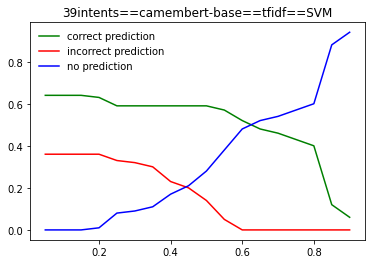

In [68]:
fig, ax = plt.subplots()

ax.plot(threshold_values, correct_pred_values, color='green', label='correct prediction')
ax.plot(threshold_values, incorrect_pred_values, color='red', label='incorrect prediction')
ax.plot(threshold_values, no_pred_values, color='blue', label='no prediction')

ax.legend(loc='best', frameon=False)

plt.title(f"{configs_name}")

plt.savefig(f"{configs_name}_thresholds.png")

plt.show()


# Conclusion

Here is some results on the dataset with 39 intents, on which the TD-IDF outperforms the BERT-based features.

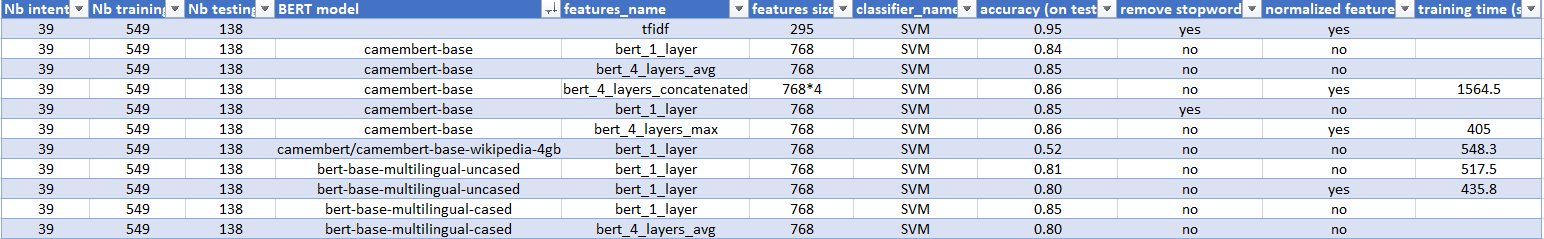

However, on the second dataset with 17 intents, the BERT features slightly outperforms the TF-IDF ones

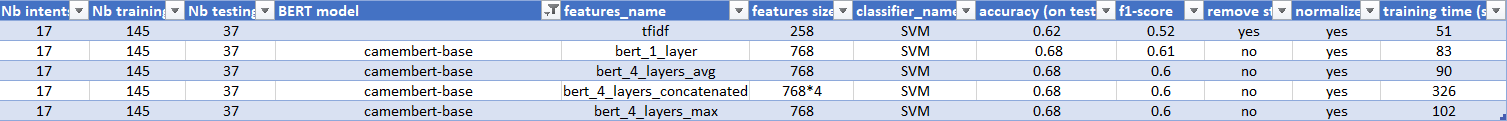

The conclusion is that there is no rule to say which features outperform others. It really depends on your dataset. In order to have the best performance, it is important to test different features for your data. It will help a lot to choose suitable features for your classification problem !